In [80]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import cv2
import time

from isingCreutzCA import isingCA
import pygame

In [81]:
from itertools import product

# toggle the brush between two modes (shortcut B)
BRUSH_TOGGLE = False

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
     # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    # doesn't do periodic boundaries
    # state[:, 1, xcl - r:xcl + r, ycl - r : ycl + r] -= (blur.cuda() + 1e-6) 
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]

    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] += blur.reshape(-1).cuda()
        state[:, 1, idx_i, idx_j] = torch.clip(state[:, 1, idx_i, idx_j], 0., HK_MAX)
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]

    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] -= blur.reshape(-1).cuda()
        state[:, 1, idx_i, idx_j] = torch.clip(state[:, 1, idx_i, idx_j], 0., HK_MAX)
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                -1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    
    return state

def WHEEL_permute(cdim_order, direction, mod):
    cdim_order = np.mod(np.add(cdim_order, direction), mod)
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [82]:
def print_beta(beta):
    fps = f'{beta:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [93]:
# resolution of grid
RESX=320
RESY=320
RES = (RESX, RESY)
HK_MAX = 128.
INIT_ORDER = 1.
INIT_ENERGY = 0.

RADIUS=2
ca = isingCA(HK_MAX, RADIUS=RADIUS).cuda()

In [94]:
# brush properties
r = RESX//50
s = 2

state = ca.initGrid(RES, INIT_ORDER, INIT_ENERGY)

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2.
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 3)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

fixed_boundaries = False

# stats to save
temps = []
mag = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, 3)

            if event.type == pygame.KEYDOWN and event.key == pygame.K_c:
                fixed_boundaries = not fixed_boundaries

            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid(RES, INIT_ORDER, INIT_ENERGY)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_b:
                BRUSH_TOGGLE = not BRUSH_TOGGLE

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        if WHEEL_trigger:
#             ca.rule.beta = WHEEL_beta(ca.rule.beta, direction)
            cdim_order = WHEEL_permute(cdim_order, direction, mod=len(cdim_order))
            WHEEL_trigger = False

        if cdim_order[0] == 0:
            spins = (state.cpu().numpy()[0, 0, :, :] + 1) /2
            momentum = state[0, -1, :, :] / ca.rule.Hk_max
            momentum = ((momentum - momentum.min()) / (momentum.max() - momentum.min()) ).cpu().numpy()
            nx = np.stack([0.7 * momentum , 154/255 * spins, 211/255 * spins]).transpose(1, 2, 0)
            nx *= 255
        elif cdim_order[0] == 1:
            spins = (state.cpu().numpy()[0, 0, :, :] + 1) /2
            nx = np.stack([0.7 * spins , 154/255 * spins, 211/255 * spins]).transpose(1, 2, 0)
            nx *= 255
        elif cdim_order[0] == 2:
            momentum = state[0, -1, :, :] / ca.rule.Hk_max
            momentum = ((momentum - momentum.min()) / (momentum.max() - momentum.min()) ).cpu().numpy()
            nx = np.stack([0.7 * momentum , 154/255 * momentum, 211/255 * momentum]).transpose(1, 2, 0)
            nx *= 255


        if time_ticking:
            state = ca.forward(state)
            ticker += 1

        if fixed_boundaries:
            decay = 0.95
            state[0, 1, :RESX//5, :] *=  decay
            state[0, 1, -RESX//5:, :] *=  decay
            state[0, 1, RESX//5:-RESX//5, -RESY//5:] *=  decay
            state[0, 1, RESX//5:-RESX//5, :RESY//5] *= decay
            state[0, 1, RESX//3:2*RESX//3, RESX//3:2*RESX//3] += 0.05
            state[0, 1] = torch.clip(state[0, 1], 0., HK_MAX)

        if export_imgs and time_ticking:
            imgs.append(nx)

        pygame.surfarray.blit_array(screen, nx)

        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))

        pygame.display.flip()
        clock.tick(240)

        
pygame.quit()


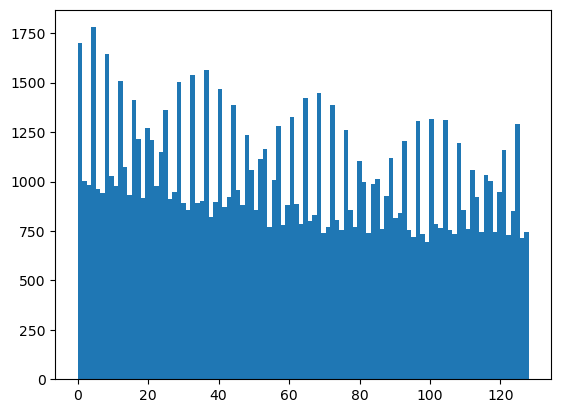

In [85]:
plt.hist(state[0, 1].cpu().numpy().reshape(-1), 100);

In [86]:
state[0, 1].min()

tensor(0.0005, device='cuda:0')

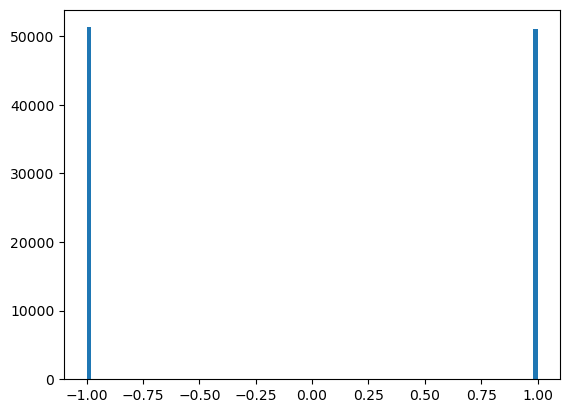

In [87]:
plt.hist(state[0, 0].cpu().numpy().reshape(-1), 100);

In [88]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
# out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 3)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    o_img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out.write(o_img)
out.release()